In [22]:
from load import load_data
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
drivers,pins = load_data()


In [23]:
def dm(x1,y1,x2,y2):
    return np.abs(x1-x2) + np.abs(y1-y2)

    pin_id      x        y
88      88  28068  1316257


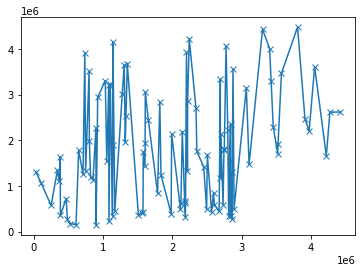

In [24]:
def come_and_go_path(points_for_path,from_x, to_x):
    # to do extrapolate through 3 points to make the paths better
    case = 1
    if to_x>from_x:#left to right:
        case =0
    elif to_x<=from_x:#left to right and back to left
        case = 2

    #left_to_right
    if case == 0: #left to right:
        path = points_for_path.sort_values(by=['x'],ascending=True)
    elif case ==1:#right to left
        path = points_for_path.sort_values(by=['x'],ascending=False)
    elif case ==2:#left to right and back to left
        maxi = points_for_path['y'].max()
        mini = points_for_path['y'].min()
        mid = (maxi - mini) / 2
        path1 = points_for_path[points_for_path['y'] > mid].sort_values(by=['x'],ascending=True)
        path2 = points_for_path[points_for_path['y'] <= mid].sort_values(by=['x'],ascending=False)
        path  = pd.concat([path1, path2])
    elif case == 3:#right to left and back to right
        maxi = points_for_path['y'].max()
        mini = points_for_path['y'].min()
        mid = (maxi - mini) / 2
        path1 = points_for_path[points_for_path['y'] > mid].sort_values(by=['x'],ascending=False)
        path2 = points_for_path[points_for_path['y'] <= mid].sort_values(by=['x'],ascending=True)
        path  = pd.concat([path1, path2])
    return path

path= come_and_go_path(pins,pins['x'].min(),pins['x'].max())
print(path.head(1))
plt.plot(path['x'],path['y'], '-x')
plt.show()


In [25]:
def pair_drivers(drivers):
    drivers_input = drivers.loc[drivers['input_output']=='INPUT'].sort_values(by= ['y'],ascending=True)
    drivers_input.reset_index(drop=True, inplace=True)
    drivers_input.columns = [c+'_input' for c in drivers_input.columns]
    drivers_output=drivers.loc[drivers['input_output']=='OUTPUT'].sort_values(by= ['y'],ascending=True)
    drivers_output.columns = [c+'_output' for c in drivers_output.columns]
    drivers_output.reset_index(drop=True, inplace=True)
    drivers =pd.merge(drivers_output, drivers_input, left_index=True, right_index=True)
    return drivers

In [26]:

def create_clusters(pins, n=2):
    x_min = np.min(pins['x'])
    y_min = np.min(pins['y'])
    x_max = np.max(pins['x'])
    y_max = np.max(pins['y'])

    xquadsize = x_max - x_min
    yquadsize = y_max - y_min
    stepy = int(yquadsize/n)
    stepx = int(xquadsize/n)
    pins['cluster_label'] = -1
    clusters = pd.DataFrame(columns=['cluster_id','x','y'])
    id = 0
    for i in range(n):
        for j in range(n):
            x = x_min+j*stepx
            y =y_min+i*stepy
            pins.loc[(pins['x']>=(x))&(pins['y']>=(y))&(pins['x']<=(x_min+(j+1)*stepx+5))&(pins['y']<=(y_min+(i+1)*stepy+5)),'cluster_label']=id
            clusters.loc[len(clusters.index)] = [id,x,y]
            id+=1
    clusters = clusters.loc[clusters['cluster_id'].isin(pins.cluster_label.unique())]
    return pins,clusters


In [27]:
# number_of_axis_cluster_splits=4
# plt.scatter(drivers.loc[drivers['input_output']=='INPUT',['x']], drivers.loc[drivers['input_output']=='INPUT',['y']],label='input')
# plt.scatter(drivers.loc[drivers['input_output']=='OUTPUT',['x']], drivers.loc[drivers['input_output']=='OUTPUT',['y']],label='output')
# for i in range(number_of_axis_cluster_splits**2):
#     plt.scatter(pins.loc[pins['cluster_label']==i,'x'],pins.loc[pins['cluster_label']==i,'y'],label=i)
# plt.legend()
# plt.show()

In [28]:
def create_cluster_paths(driver_pairs,clusters):
    number_of_paths = len(driver_pairs)
    cluster_paths = []
    number_of_clusters = len(clusters)
    clusters = clusters.sort_values(by=['y'],ascending=False)
    number_of_clusters_per_path = int(number_of_clusters/number_of_paths)
    driver_pairs.loc[0,'cluster_path'] = int(0)
    cluster_paths.append(clusters[0:number_of_clusters_per_path])
    for i in range(1,number_of_paths-1):
        # print(clusters[(i*number_of_clusters_per_path):((i+1)*number_of_clusters_per_path)]['cluster_label'].to_list())
        cluster_paths.append(clusters[(i*number_of_clusters_per_path):((i+1)*number_of_clusters_per_path)])
        driver_pairs.loc[i,'cluster_path'] = int(i)
    cluster_paths.append(clusters[number_of_paths-1:])
    driver_pairs.loc[i+1,'cluster_path'] = int(i+1)
    driver_pairs['cluster_path']= driver_pairs['cluster_path'].astype('int64')
    return driver_pairs,cluster_paths

In [39]:
#algorithm
drivers,pins = load_data()
drivers = pair_drivers(drivers)
number_of_axis_cluster_splits = 2*len(drivers)
pins,clusters = create_clusters(pins,n=number_of_axis_cluster_splits)
drivers, cluster_paths = create_cluster_paths(drivers,clusters)

for index,row in drivers.iterrows():
    cluster_set = cluster_paths[row.cluster_path]
    cluster_path_optimised = come_and_go_path(cluster_set,row.x_output,row.x_input)
    total_manhattan_distance = 0
    previous_point_measured_from = [row.x_output,row.y_output]
    for i in range(len(cluster_path_optimised)-1):
        pins_path = come_and_go_path(pins.loc[pins['cluster_label']==cluster_path_optimised.iloc[i].cluster_id], cluster_path_optimised.iloc[i].x,cluster_path_optimised.iloc[i+1].x)
        for pi,pr in pins_path.iterrows():
            total_manhattan_distance += dm(previous_point_measured_from[0],previous_point_measured_from[1],pr.x,pr.y)
            previous_point_measured_from = [pr.x,pr.y]

    i = len(cluster_path_optimised)-1
    pins_path = come_and_go_path(pins.loc[pins['cluster_label']==cluster_path_optimised.iloc[i].cluster_id], cluster_path_optimised.iloc[i].x,row.x_input)
    for pi,pr in pins_path.iterrows():
        total_manhattan_distance += dm(previous_point_measured_from[0],previous_point_measured_from[1],pr.x,pr.y)
        previous_point_measured_from = [pr.x,pr.y]

    total_manhattan_distance+=dm(previous_point_measured_from[0],previous_point_measured_from[1],row.x_input,row.y_input)
    print('manhattan distance for path x',total_manhattan_distance)

manhattan distance for path x 14879894
manhattan distance for path x 13054531
manhattan distance for path x 14569610
manhattan distance for path x 11851294
manhattan distance for path x 13202028
manhattan distance for path x 12129003
manhattan distance for path x 11463170
manhattan distance for path x 10016198
manhattan distance for path x 10849316
manhattan distance for path x 7677165
manhattan distance for path x 8043544
manhattan distance for path x 6948936
manhattan distance for path x 6461134
manhattan distance for path x 6407947
manhattan distance for path x 7014764
manhattan distance for path x 51016394
